In [2]:
import numpy 
#from pydub import AudioSegment
import sys
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
import IPython.display as ipd
import sys
import time
import xml.etree.ElementTree as et
import pandas as pd

import librosa
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display
import os
import pickle
from pydub import AudioSegment
from pydub.playback import play

In [1]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Read File 

In [3]:
audio_path='/content/Breaking-Metal-Bottle-Impact-A1-www.fesliyanstudios.com (1).wav'
frameSize = 0.250
frameStep = 0.075
discard = 21

In [4]:
def readAudioFile(path):
    '''
    This function returns a numpy array that stores the audio samples of a specified WAV file
    '''
    try:
        x , sr = librosa.load(audio_path,res_type='kaiser_fast',sr=None)
    except IOError: 
        print("Error: file not found or other I/O error.")
        return (-1,-1)

    if x.ndim == 2:
        if x.shape[1] == 1:
            x = x.flatten()

    return (sr, x)

#Time-domain audio features

In [5]:
def stZCR(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    countZ = numpy.sum(numpy.abs(numpy.diff(numpy.sign(frame)))) / 2
    return (numpy.float64(countZ) / numpy.float64(count-1.0))

In [6]:
def stEnergy(frame):
    """Computes signal energy of frame"""
    return numpy.sum(frame ** 2) / numpy.float64(len(frame))

In [7]:
eps = 0.00000001
def stEnergyEntropy(frame, numOfShortBlocks=10):
    """Computes entropy of energy"""
    Eol = numpy.sum(frame ** 2)    # total frame energy
    L = len(frame)
    subWinLength = int(numpy.floor(L / numOfShortBlocks))
    if L != subWinLength * numOfShortBlocks:
            frame = frame[0:subWinLength * numOfShortBlocks]
    # subWindows is of size [numOfShortBlocks x L]
    subWindows = frame.reshape(subWinLength, numOfShortBlocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = numpy.sum(subWindows ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -numpy.sum(s * numpy.log2(s + eps))
    return Entropy

#Frequency-domain audio features

In [8]:
def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (numpy.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = numpy.sum(ind * Xt)
    DEN = numpy.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = numpy.sqrt(numpy.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)

In [9]:
def stSpectralEntropy(X, numOfShortBlocks=10):
    """Computes the spectral entropy"""
    L = len(X)                         # number of frame samples
    Eol = numpy.sum(X ** 2)            # total spectral energy

    subWinLength = int(numpy.floor(L / numOfShortBlocks))   # length of sub-frame
    if L != subWinLength * numOfShortBlocks:
        X = X[0:subWinLength * numOfShortBlocks]

    subWindows = X.reshape(subWinLength, numOfShortBlocks, order='F').copy()  # define sub-frames (using matrix reshape)
    s = numpy.sum(subWindows ** 2, axis=0) / (Eol + eps)                      # compute spectral sub-energies
    En = -numpy.sum(s*numpy.log2(s + eps))                                    # compute spectral entropy

    return En

In [10]:
def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    totalEnergy = numpy.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position where the respective spectral energy is equal to c*totalEnergy
    CumSum = numpy.cumsum(X ** 2) + eps
    [a, ] = numpy.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = numpy.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)

In [11]:
def stSpectralFlux(X, Xprev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:        the abs(fft) of the current frame
        Xpre:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    sumX = numpy.sum(X + eps)
    sumPrevX = numpy.sum(Xprev + eps)
    F = numpy.sum((X / sumX - Xprev/sumPrevX) ** 2)

    return F

In [12]:
def mfccInitFilterBanks(fs, nfft):
    """
    Computes the triangular filterbank for MFCC computation (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    # filter bank params:
    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    numLinFiltTotal = 13
    numLogFilt = 27

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt

    # Compute frequency points of the triangle:
    freqs = numpy.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + numpy.arange(numLinFiltTotal) * linsc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** numpy.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = numpy.zeros((nFiltTotal, nfft))
    nfreqs = numpy.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = numpy.arange(numpy.floor(lowTrFreq * nfft / fs) + 1, numpy.floor(cenTrFreq * nfft / fs) + 1, dtype=numpy.int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = numpy.arange(numpy.floor(cenTrFreq * nfft / fs) + 1, numpy.floor(highTrFreq * nfft / fs) + 1, dtype=numpy.int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs

In [13]:
def stMFCC(X, fbank, nceps):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        X:        fft magnitude abs(FFT)
        fbank:    filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:     MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = numpy.log10(numpy.dot(X, fbank.T)+eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:nceps]
    return ceps

#Get Feature 

In [14]:
def stFeatureExtraction(signal, Fs, Win, Step):
    Win = int(Win)
    Step = int(Step)

    # Signal normalization
    signal = numpy.double(signal)

    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX + 0.0000000001)

    N = len(signal)                                # total number of samples
    curPos = 0
    countFrames = 0
    nFFT = int(Win / 2)

    [fbank, freqs] = mfccInitFilterBanks(Fs, nFFT)                # compute the triangular filter banks used in the mfcc calculation

    numOfTimeSpectralFeatures = 8
    numOfHarmonicFeatures = 0
    nceps = 13
    numOfChromaFeatures = 13
    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures + numOfChromaFeatures

    i =0 
    stFeatures = []
    #stfeat ={}
    #finalfeat=[]
    while (curPos + Win - 1 < N):                        # for each short-term window until the end of signal
        countFrames += 1
        i = i+1
        #print(i)
        x = signal[curPos:curPos+Win]                    # get current window
        curPos = curPos + Step                           # update window position
        X = abs(fft(x))                                  # get fft magnitude
        X = X[0:nFFT]                                    # normalize fft
        X = X / len(X)
        if countFrames == 1:
            Xprev = X.copy()                             # keep previous fft mag (used in spectral flux)
        curFV = numpy.zeros((totalNumOfFeatures, 1))
        curFV[0] = stZCR(x)                              # zero crossing rate
        curFV[1] = stEnergy(x)                           # short-term energy
        curFV[2] = stEnergyEntropy(x)                    # short-term entropy of energy
        [curFV[3], curFV[4]] = stSpectralCentroidAndSpread(X, Fs)    # spectral centroid and spread
        curFV[5] = stSpectralEntropy(X)                  # spectral entropy
        curFV[6] = stSpectralFlux(X, Xprev)              # spectral flux
        curFV[7] = stSpectralRollOff(X, 0.90, Fs)        # spectral rolloff
        curFV[numOfTimeSpectralFeatures:numOfTimeSpectralFeatures+nceps, 0] = stMFCC(X, fbank, nceps).copy()    # MFCCs

        stFeatures.append(curFV)

        Xprev = X.copy()

    stFeatures = numpy.concatenate(stFeatures, 1)
    return stFeatures

In [15]:
def getFeature(signal, Fs, Win, Step):
    #featurefinall =[]
    F =stFeatureExtraction(signal,Fs,Win,Step)
    raw_feature = F[:discard, :].T
    feature = []
    tmp = []
    for j in range(0, raw_feature.shape[1]):  # compute median and med for each columns
        feature_column = raw_feature[:, j]
        median = numpy.median(raw_feature[:, j])
        median_absolute_deviation = numpy.median(numpy.abs(feature_column - median))
        tmp.append(median)
        tmp.append(median_absolute_deviation)
        
    feature.append(tmp)
    i =0
    feature1={}
    #feature1[new_f]=xx
    for x in feature:
        feature1['zero-crossing-median']=x[0]
        feature1['short-term-energy-median']=x[1]
        feature1['short-term-entropy-median']=x[2]
        feature1['spectral-centroid1-median']=x[3]
        feature1['spectral-centroid2-median']=x[4]
        feature1['spectral-entropy-median']=x[5]
        feature1['spectral-flux-median']=x[6]
        feature1['spectral-rolloff-median']=x[7]
        feature1['MFCCs1-median']=x[8]
        feature1['MFCCs2-median']=x[9]
        feature1['MFCCs3-median']=x[10]
        feature1['MFCCs4-median']=x[11]
        feature1['MFCCs5-median']=x[12]
        feature1['MFCCs6-median']=x[13]
        feature1['MFCCs7-median']=x[14]
        feature1['MFCCs8-median']=x[15]
        feature1['MFCCs9-median']=x[16]
        feature1['MFCCs10-median']=x[17]
        feature1['MFCCs11-median']=x[18]
        feature1['MFCCs12-median']=x[19]
        feature1['MFCCs13-median']=x[20]
        feature1['zero-crossing-deviation']=x[21]
        feature1['short-term-energy-deviation']=x[22]
        feature1['short-term-entropy-deviation']=x[23]
        feature1['spectral-centroid1-deviation']=x[24]
        feature1['spectral-centroid2-deviation']=x[25]
        feature1['spectral-entropy-deviation']=x[26]
        feature1['spectral-flux-deviation']=x[27]
        feature1['spectral-rolloff-deviation']=x[28]
        feature1['MFCCs1-deviation']=x[29]
        feature1['MFCCs2-deviation']=x[30]
        feature1['MFCCs3-deviation']=x[31]
        feature1['MFCCs4-deviation']=x[32]
        feature1['MFCCs5-deviation']=x[33]
        feature1['MFCCs6-deviation']=x[34]
        feature1['MFCCs7-deviation']=x[35]
        feature1['MFCCs8-deviation']=x[36]
        feature1['MFCCs9-deviation']=x[37]
        feature1['MFCCs10-deviation']=x[38]
        feature1['MFCCs11-deviation']=x[39]
        feature1['MFCCs12-deviation']=x[40]
        feature1['MFCCs13-deviation']=x[41]
    return feature1

In [16]:
x1, Fs = librosa.load(audio_path,res_type='kaiser_fast')

In [17]:
Fs

22050

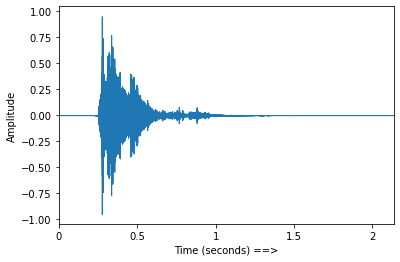

In [18]:
plt.figure()
librosa.display.waveplot(y=x1, sr=Fs)
plt.xlabel("Time (seconds) ==>")
plt.ylabel("Amplitude")
plt.show()

In [19]:
ipd.Audio(audio_path)

In [20]:
n_fft = 2048
S = librosa.stft(x1, n_fft=n_fft, hop_length=n_fft//2)
print(S.shape)
# convert to db
D = librosa.amplitude_to_db(numpy.abs(S), ref=numpy.max)
numpy.max(abs(D))

(1025, 46)


80.0

In [21]:
nonMuteSections = librosa.effects.split(x1)  # split audio with any audio signal lesser than 20db as mute
nonMuteSections

array([[ 4608, 29696]])

In [22]:
def displayTime(startFrame, endFrame):    
    print(' start time: ' + str(startFrame/Fs) + ', end time: ' + str(endFrame/Fs))
    print()

In [23]:
def Get(signal, Fs, Win, Step):
    Win = int(Win)
    Step = int(Step)

    # Signal normalization
    signal = numpy.double(signal)

    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX + 0.0000000001)

    N = len(signal)                                # total number of samples
    curPos = 0
    countFrames = 0
    x = []
    while (curPos + Win - 1 < N):                        # for each short-term window until the end of signal
        countFrames += 1
        x.append(signal[curPos:curPos+Win])                 # get current window
        print(displayTime(curPos,curPos+Win))
        #print(x)
        curPos = curPos + Step                           # update window position
       
    return x

In [24]:
type(x1)

numpy.ndarray

In [25]:
F1 = []
#for x in signal:
F=getFeature(x1,Fs,frameSize * Fs,frameStep * Fs)
newF = {}
newF['MFCCs1-deviation'] = F['MFCCs1-deviation']
newF['MFCCs1-median'] = F['MFCCs1-median']
newF['MFCCs10-deviation'] = F['MFCCs10-deviation']
newF['MFCCs10-median'] = F['MFCCs10-median']
newF['MFCCs11-deviation'] = F['MFCCs11-deviation']
newF['MFCCs11-median'] = F ['MFCCs11-median']
newF['MFCCs12-deviation'] = F['MFCCs12-deviation']
newF['MFCCs12-median'] = F['MFCCs12-median']
newF['MFCCs13-deviation'] = F['MFCCs13-deviation']
newF['MFCCs13-median'] = F['MFCCs13-median']
newF['MFCCs2-deviation'] = F['MFCCs2-deviation']
newF['MFCCs2-median'] = F['MFCCs2-median']
newF['MFCCs3-deviation'] = F['MFCCs3-deviation']
newF['MFCCs3-median'] =   F['MFCCs3-median']
newF['MFCCs4-deviation'] = F['MFCCs4-deviation']
newF['MFCCs4-median'] = F['MFCCs4-median']
newF['MFCCs5-deviation'] =F['MFCCs5-deviation']
newF['MFCCs5-median'] = F['MFCCs5-median']
newF['MFCCs6-deviation'] = F['MFCCs6-deviation']
newF['MFCCs6-median'] = F['MFCCs6-median']
newF['MFCCs7-deviation'] = F['MFCCs7-deviation']
newF['MFCCs7-median'] = F['MFCCs7-median']
newF['MFCCs8-deviation'] = F['MFCCs8-deviation']
newF['MFCCs8-median'] = F['MFCCs8-median']
newF['MFCCs9-deviation'] = F['MFCCs9-deviation']
newF['MFCCs9-median'] = F['MFCCs9-median']
newF['short-term-energy-deviation'] = F['short-term-energy-deviation']
newF['short-term-energy-median'] = F['short-term-energy-median']
newF['short-term-entropy-deviation'] = F['short-term-entropy-deviation']
newF['short-term-entropy-median'] = F['short-term-entropy-median']
newF['spectral-centroid1-deviation'] = F['spectral-centroid1-deviation']
newF['spectral-centroid1-median'] = F['spectral-centroid1-median']
newF['spectral-centroid2-deviation'] = F['spectral-centroid2-deviation']
newF['spectral-centroid2-median'] = F['spectral-centroid2-median']
newF['spectral-entropy-deviation'] = F['spectral-entropy-deviation']
newF['spectral-entropy-median'] = F['spectral-entropy-median']
newF['spectral-flux-deviation'] = F['spectral-flux-deviation']
newF['spectral-flux-median'] = F['spectral-flux-median']
newF['spectral-rolloff-deviation'] = F['spectral-rolloff-deviation']
newF['spectral-rolloff-median'] = F['spectral-rolloff-median']
newF['zero-crossing-deviation'] = F['zero-crossing-deviation']
newF['zero-crossing-median'] = F['zero-crossing-median']
#    F1.append(newF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [26]:
df = pd.DataFrame()
df3 = pd.DataFrame()
df2 = df.append(newF, ignore_index = True)
#df3 = pd.concat([df2,df3],axis = 0)

In [27]:
df2.head(10)

,MFCCs1-deviation,MFCCs1-median,MFCCs10-deviation,MFCCs10-median,MFCCs11-deviation,MFCCs11-median,MFCCs12-deviation,MFCCs12-median,MFCCs13-deviation,MFCCs13-median,...,spectral-centroid2-deviation,spectral-centroid2-median,spectral-entropy-deviation,spectral-entropy-median,spectral-flux-deviation,spectral-flux-median,spectral-rolloff-deviation,spectral-rolloff-median,zero-crossing-deviation,zero-crossing-median
0,0.157547,0.23084,-0.005969,9.566346,0.063989,0.792222,-0.079915,0.522159,0.081356,-0.649597,...,0.145268,2.529681,0.092617,0.420047,0.180309,0.228628,-0.096619,0.071121,0.299379,0.154237


In [28]:
df2.shape

(1, 42)

In [29]:
df2.columns

Index(['MFCCs1-deviation', 'MFCCs1-median', 'MFCCs10-deviation',
       'MFCCs10-median', 'MFCCs11-deviation', 'MFCCs11-median',
       'MFCCs12-deviation', 'MFCCs12-median', 'MFCCs13-deviation',
       'MFCCs13-median', 'MFCCs2-deviation', 'MFCCs2-median',
       'MFCCs3-deviation', 'MFCCs3-median', 'MFCCs4-deviation',
       'MFCCs4-median', 'MFCCs5-deviation', 'MFCCs5-median',
       'MFCCs6-deviation', 'MFCCs6-median', 'MFCCs7-deviation',
       'MFCCs7-median', 'MFCCs8-deviation', 'MFCCs8-median',
       'MFCCs9-deviation', 'MFCCs9-median', 'short-term-energy-deviation',
       'short-term-energy-median', 'short-term-entropy-deviation',
       'short-term-entropy-median', 'spectral-centroid1-deviation',
       'spectral-centroid1-median', 'spectral-centroid2-deviation',
       'spectral-centroid2-median', 'spectral-entropy-deviation',
       'spectral-entropy-median', 'spectral-flux-deviation',
       'spectral-flux-median', 'spectral-rolloff-deviation',
       'spectral-rolloff-m

In [30]:
filename = '/content/finalBoosting_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

In [31]:
ypredict = loaded_model.predict(df2)

In [32]:
ypredict

array([0])